## Imports

In [1]:
import pandas as pd 
import numpy as np
import re

##LDA stuff
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

##cleaning stuff
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel

##plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns

## Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

In [3]:
def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum()]
    tokens = [word.lower() for word in tokens]
    return tokens

In [4]:
def remove_non_english_words(text, valid_words):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() in valid_words]
    return ' '.join(ans)

def remove_stopwords(text):
    tokens = word_tokenize(text)
    ans = [w for w in tokens if w.lower() not in stop_words]
    return ' '.join(ans)

In [5]:
df_ibis = pd.read_csv('../../../data/processed/cleaned_ibis-sg-bencoolen.csv')
df_boss = pd.read_csv('../../../data/processed/cleaned_hotel-boss.csv')
df_g = pd.read_csv('../../../data/processed/cleaned_hotel-G.csv')
df_village = pd.read_csv('../../../data/processed/cleaned_village-hotel-albert-court-by-far-east-hospitality.csv')
df_holiday = pd.read_csv('../../../data/processed/cleaned_holiday-inn-express-clarke-quay.csv')


df_combi = pd.concat([df_ibis, df_boss, df_g, df_village, df_holiday]) ##combines the files together

To ensure our files do not include irrelevant words, we have extended the stopwords from nltk to include relevant stopwords from the files below.

In [6]:
##filter for year >= 2015
df_filtered = df_combi[df_combi['date'] >= '2015-01-01']

##preprocess text
nltk.download('stopwords')
nltk.download('words')
# Get the list of valid English words
english_words = set(words.words())
# set stopwords
sw = stopwords.words('english')
sw.extend(['ibis', 'boss', 'village', 'ibis_bencoolen', 'bencoolen', 'albert', 'far_east', 'east_hospitality',
           'clarke', 'quay', 'express', 'clarke_quay', 'albert_court', 'court', 'clark', 'inn', 'marina'])

stop_words = set(sw)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Chen
[nltk_data]     Wei\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


To analyse whether using a stemmed version of the reviews or a lemmatized version of the reviews would produce better LDA results, we will be conducting analysis on both. The reviews will be determined by the coherence score of both stemmed and lemmatized reviews.

## Stemmed

In [7]:
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_stopwords)
df_filtered['stem_review'] = df_filtered['stem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['stem_tokens'] = df_filtered['stem_review'].apply(preprocess)

In [8]:
##Generate LDA dictionary and corpus
#stem_dict = corpora.Dictionary(df_filtered['stem_tokens']) #used if we want to refresh it
#stem_dict.save('3star_stem')
stem_dict = corpora.Dictionary.load('3star_stem')
stem_corpus = [stem_dict.doc2bow(text) for text in df_filtered['stem_tokens']]

In [10]:
## find best_coherence (Don't run, takes too long to run):
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    stem_ldamodel = lda(stem_corpus, num_topics=i, id2word=stem_dict, passes=15, random_state=0)
    
    stemming_coherence = CoherenceModel(model=stem_ldamodel, texts=df_filtered['stem_tokens'], 
                                        dictionary=stem_dict, coherence='c_v')
    lda_coherence = stemming_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.42285387221871173
The coherence score at topic 3 is 0.4516240365942341
The coherence score at topic 4 is 0.472767772900985
The coherence score at topic 5 is 0.43860426544957676
The coherence score at topic 6 is 0.460821525548224


In [9]:
## Use 4 topics as indicated by coherence
lda = gensim.models.ldamodel.LdaModel
stem_ldamodel = lda(stem_corpus, num_topics=4, id2word=stem_dict, passes=15, random_state=0)

In [10]:
# For stemming
topics_stem = stem_ldamodel.show_topics(formatted=False, num_words=20)
data_flat_stem = [word for word_list in df_filtered['stem_tokens'] for word in word_list]

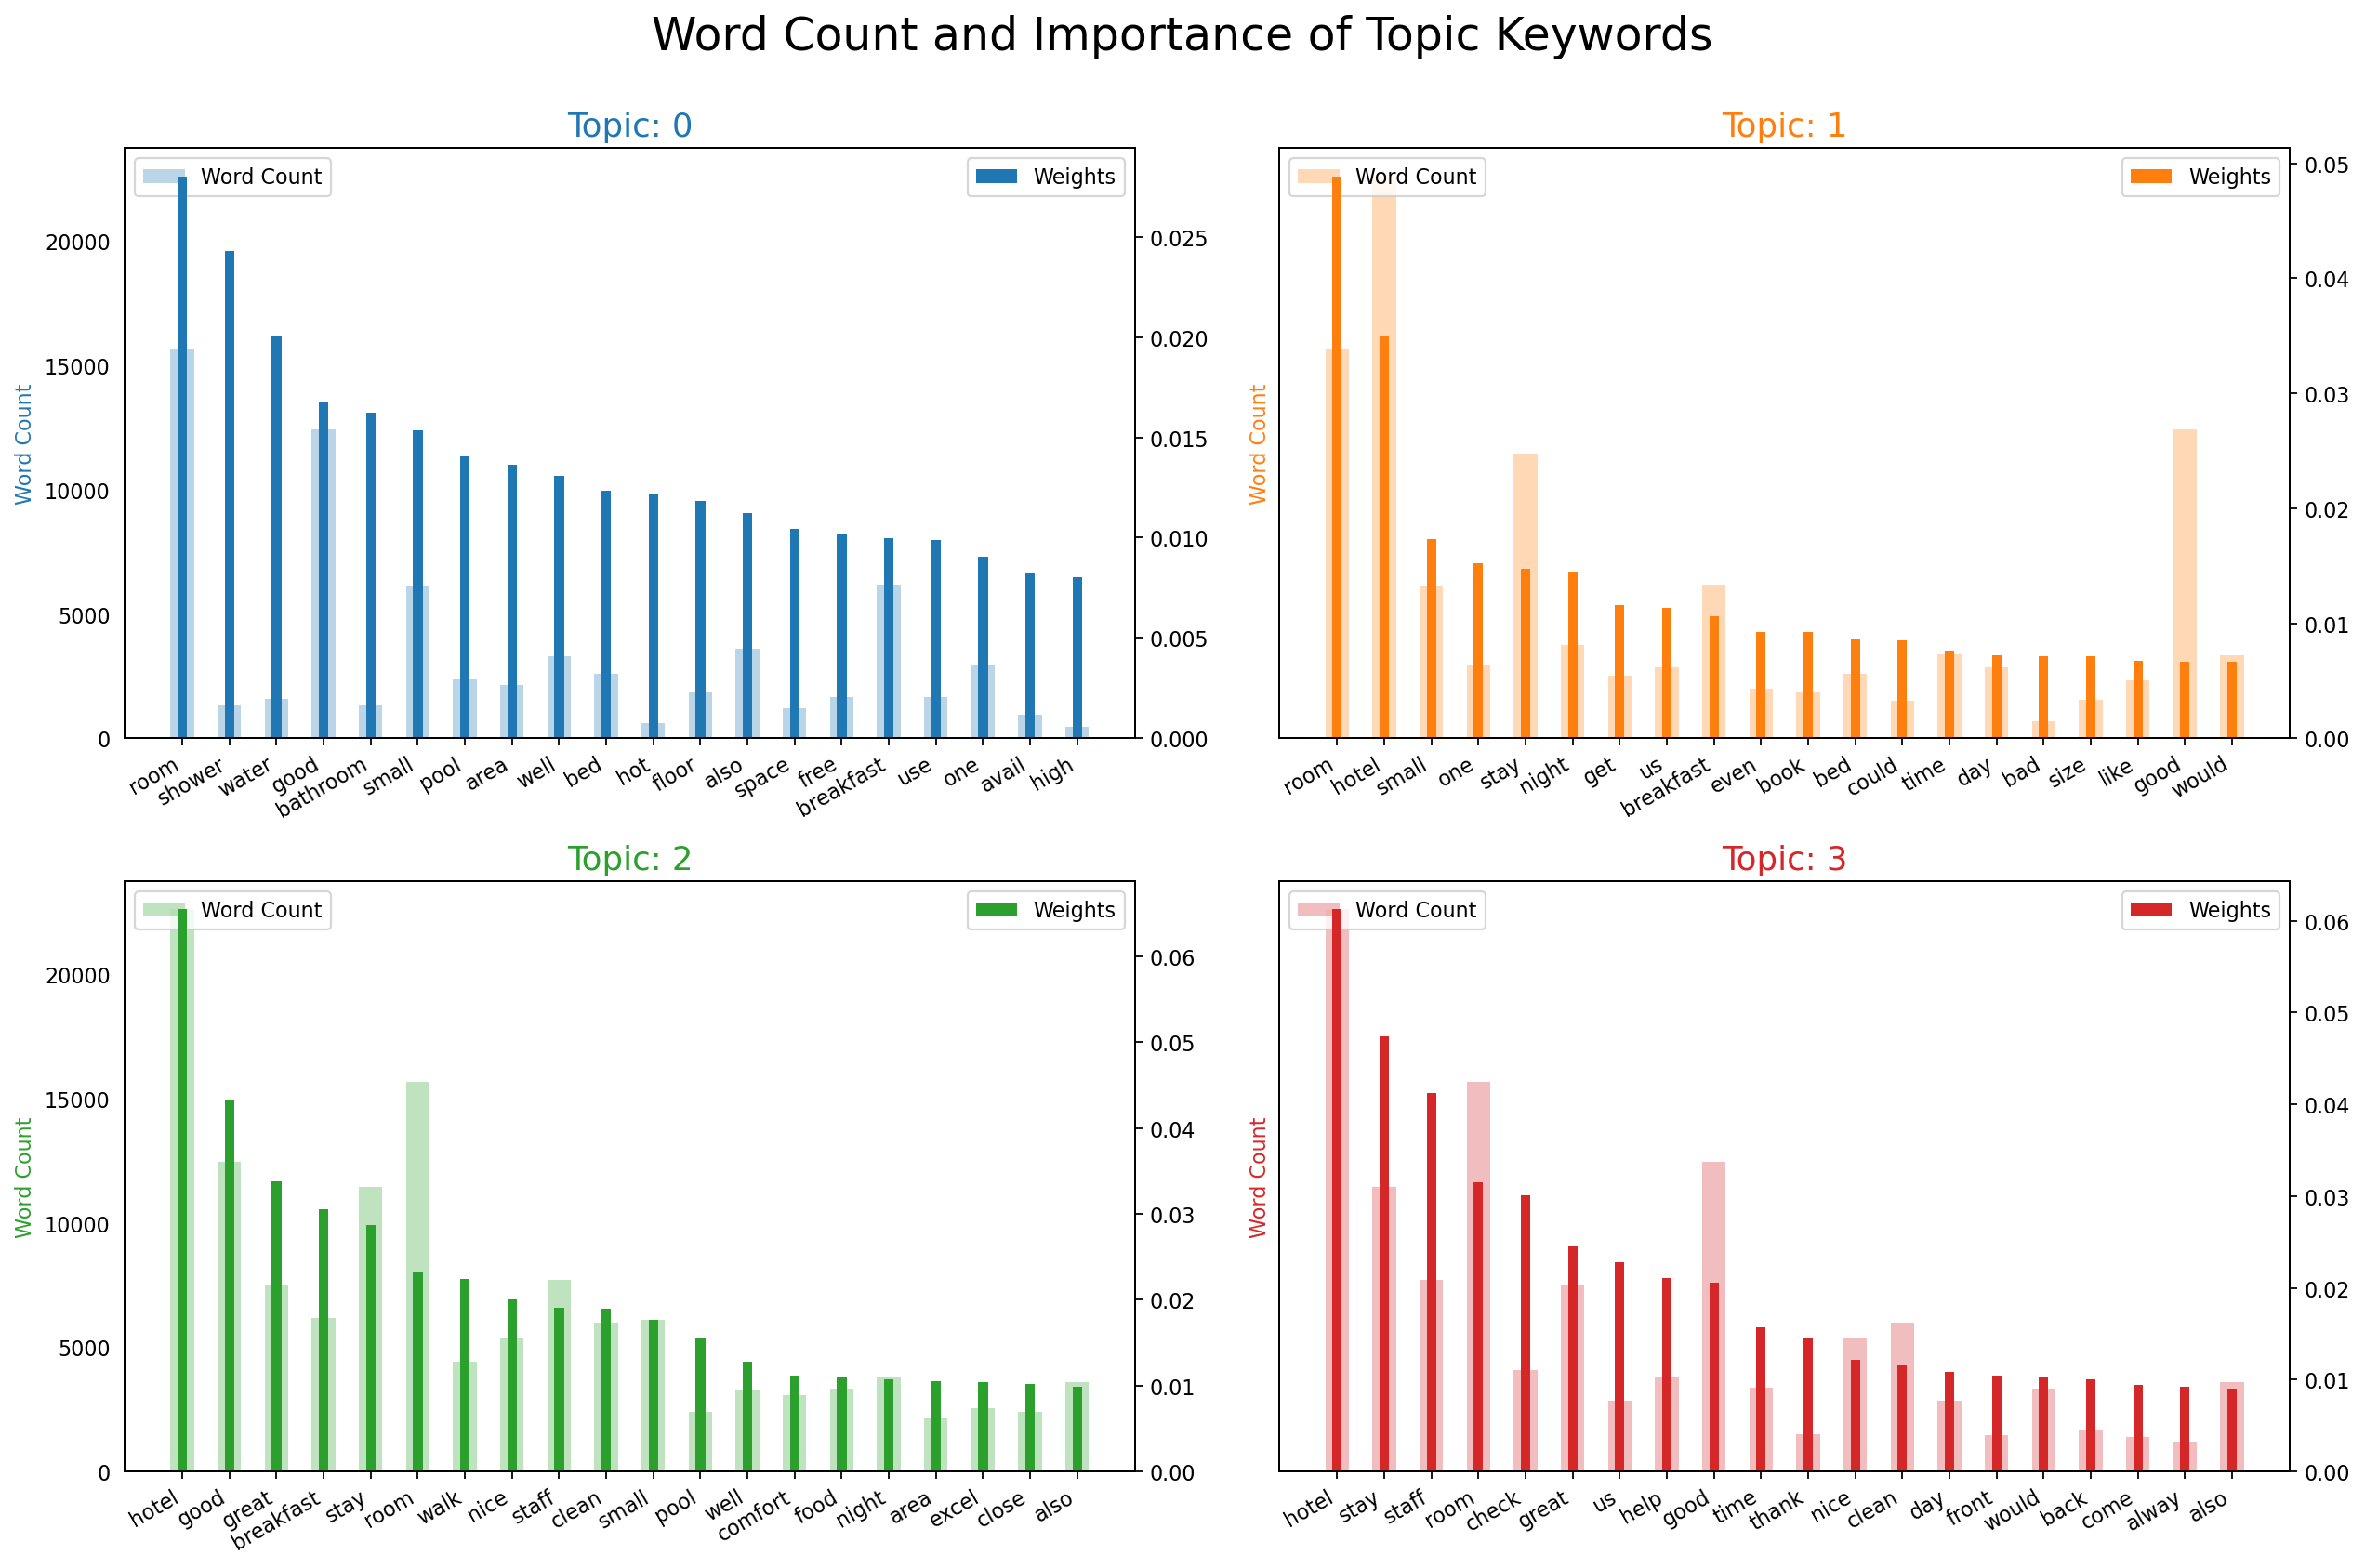

In [11]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# For all topics
plot_word_count_importance(topics_stem, data_flat_stem, 'Word Count and Importance of Topic Keywords')

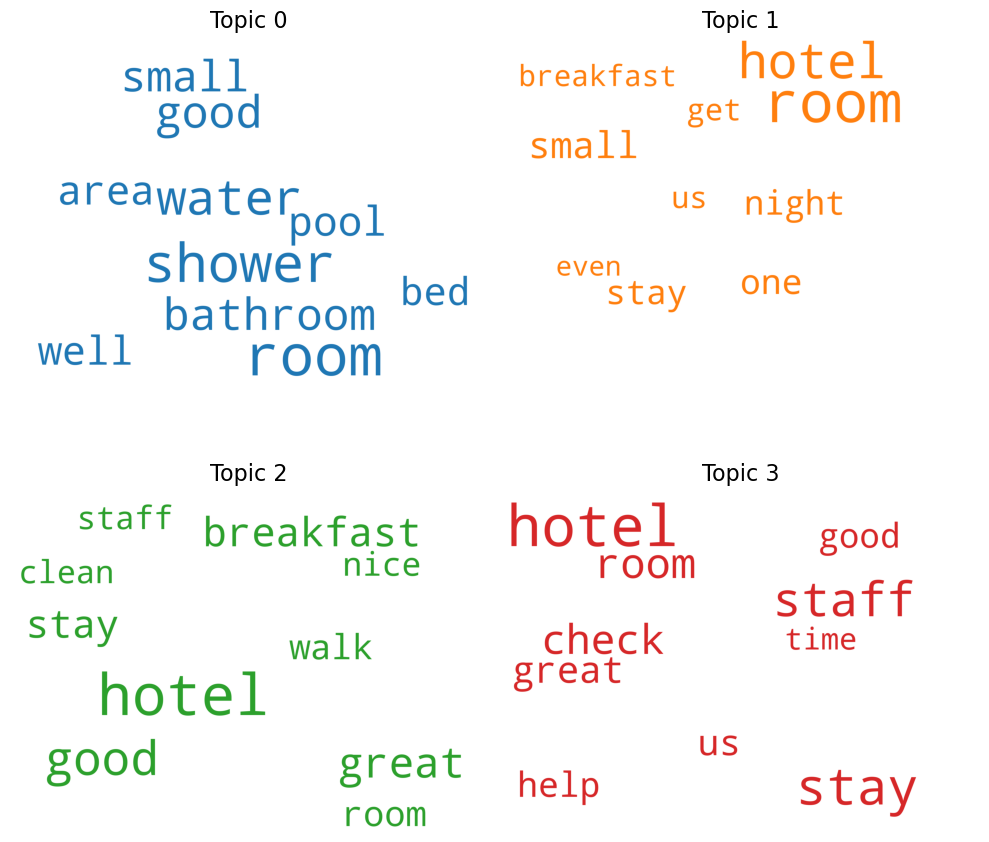

In [17]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the dataset
clouds_pre = []

for i in range(4):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(stem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for all topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [13]:
vis = pyLDAvis.gensim.prepare(topic_model=stem_ldamodel, corpus=stem_corpus, dictionary=stem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## Lemmatized

In [18]:
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_stopwords)
df_filtered['lem_review'] = df_filtered['lem_review'].apply(remove_non_english_words, valid_words=english_words)
df_filtered['lem_tokens'] = df_filtered['lem_review'].apply(preprocess)

In [19]:
##Generate LDA dictionary and corpus
#lem_dict = corpora.Dictionary(df_filtered['lem_tokens']) #used if you want to refresh dict
#lem_dict.save('3star_lem')
lem_dict = corpora.Dictionary.load('3star_lem')
lem_corpus = [lem_dict.doc2bow(text) for text in df_filtered['lem_tokens']]

In [20]:
## find best_coherence (Don't run, takes too long to run):
for i in range(2, 7):
    lda = gensim.models.ldamodel.LdaModel
    lem_ldamodel = lda(lem_corpus, num_topics=i, id2word=lem_dict, passes=15, random_state=0)
    
    lem_coherence = CoherenceModel(model=lem_ldamodel, texts=df_filtered['lem_tokens'], dictionary=lem_dict, coherence='c_v')
    lda_coherence = lem_coherence.get_coherence()
    print(f"The coherence score at topic {i} is {lda_coherence}")

The coherence score at topic 2 is 0.3757793787059268
The coherence score at topic 3 is 0.41811331888212616
The coherence score at topic 4 is 0.4152177468497111
The coherence score at topic 5 is 0.41065431086001114
The coherence score at topic 6 is 0.40850478411168006


In [21]:
## Use 3 topics as determined by coherence
lda = gensim.models.ldamodel.LdaModel
lem_ldamodel = lda(lem_corpus, num_topics=3, id2word=lem_dict, passes=15, random_state=0)

In [22]:
# For All
topics_lem = lem_ldamodel.show_topics(formatted=False)
data_flat_lem = [word for word_list in df_filtered['lem_tokens'] for word in word_list]

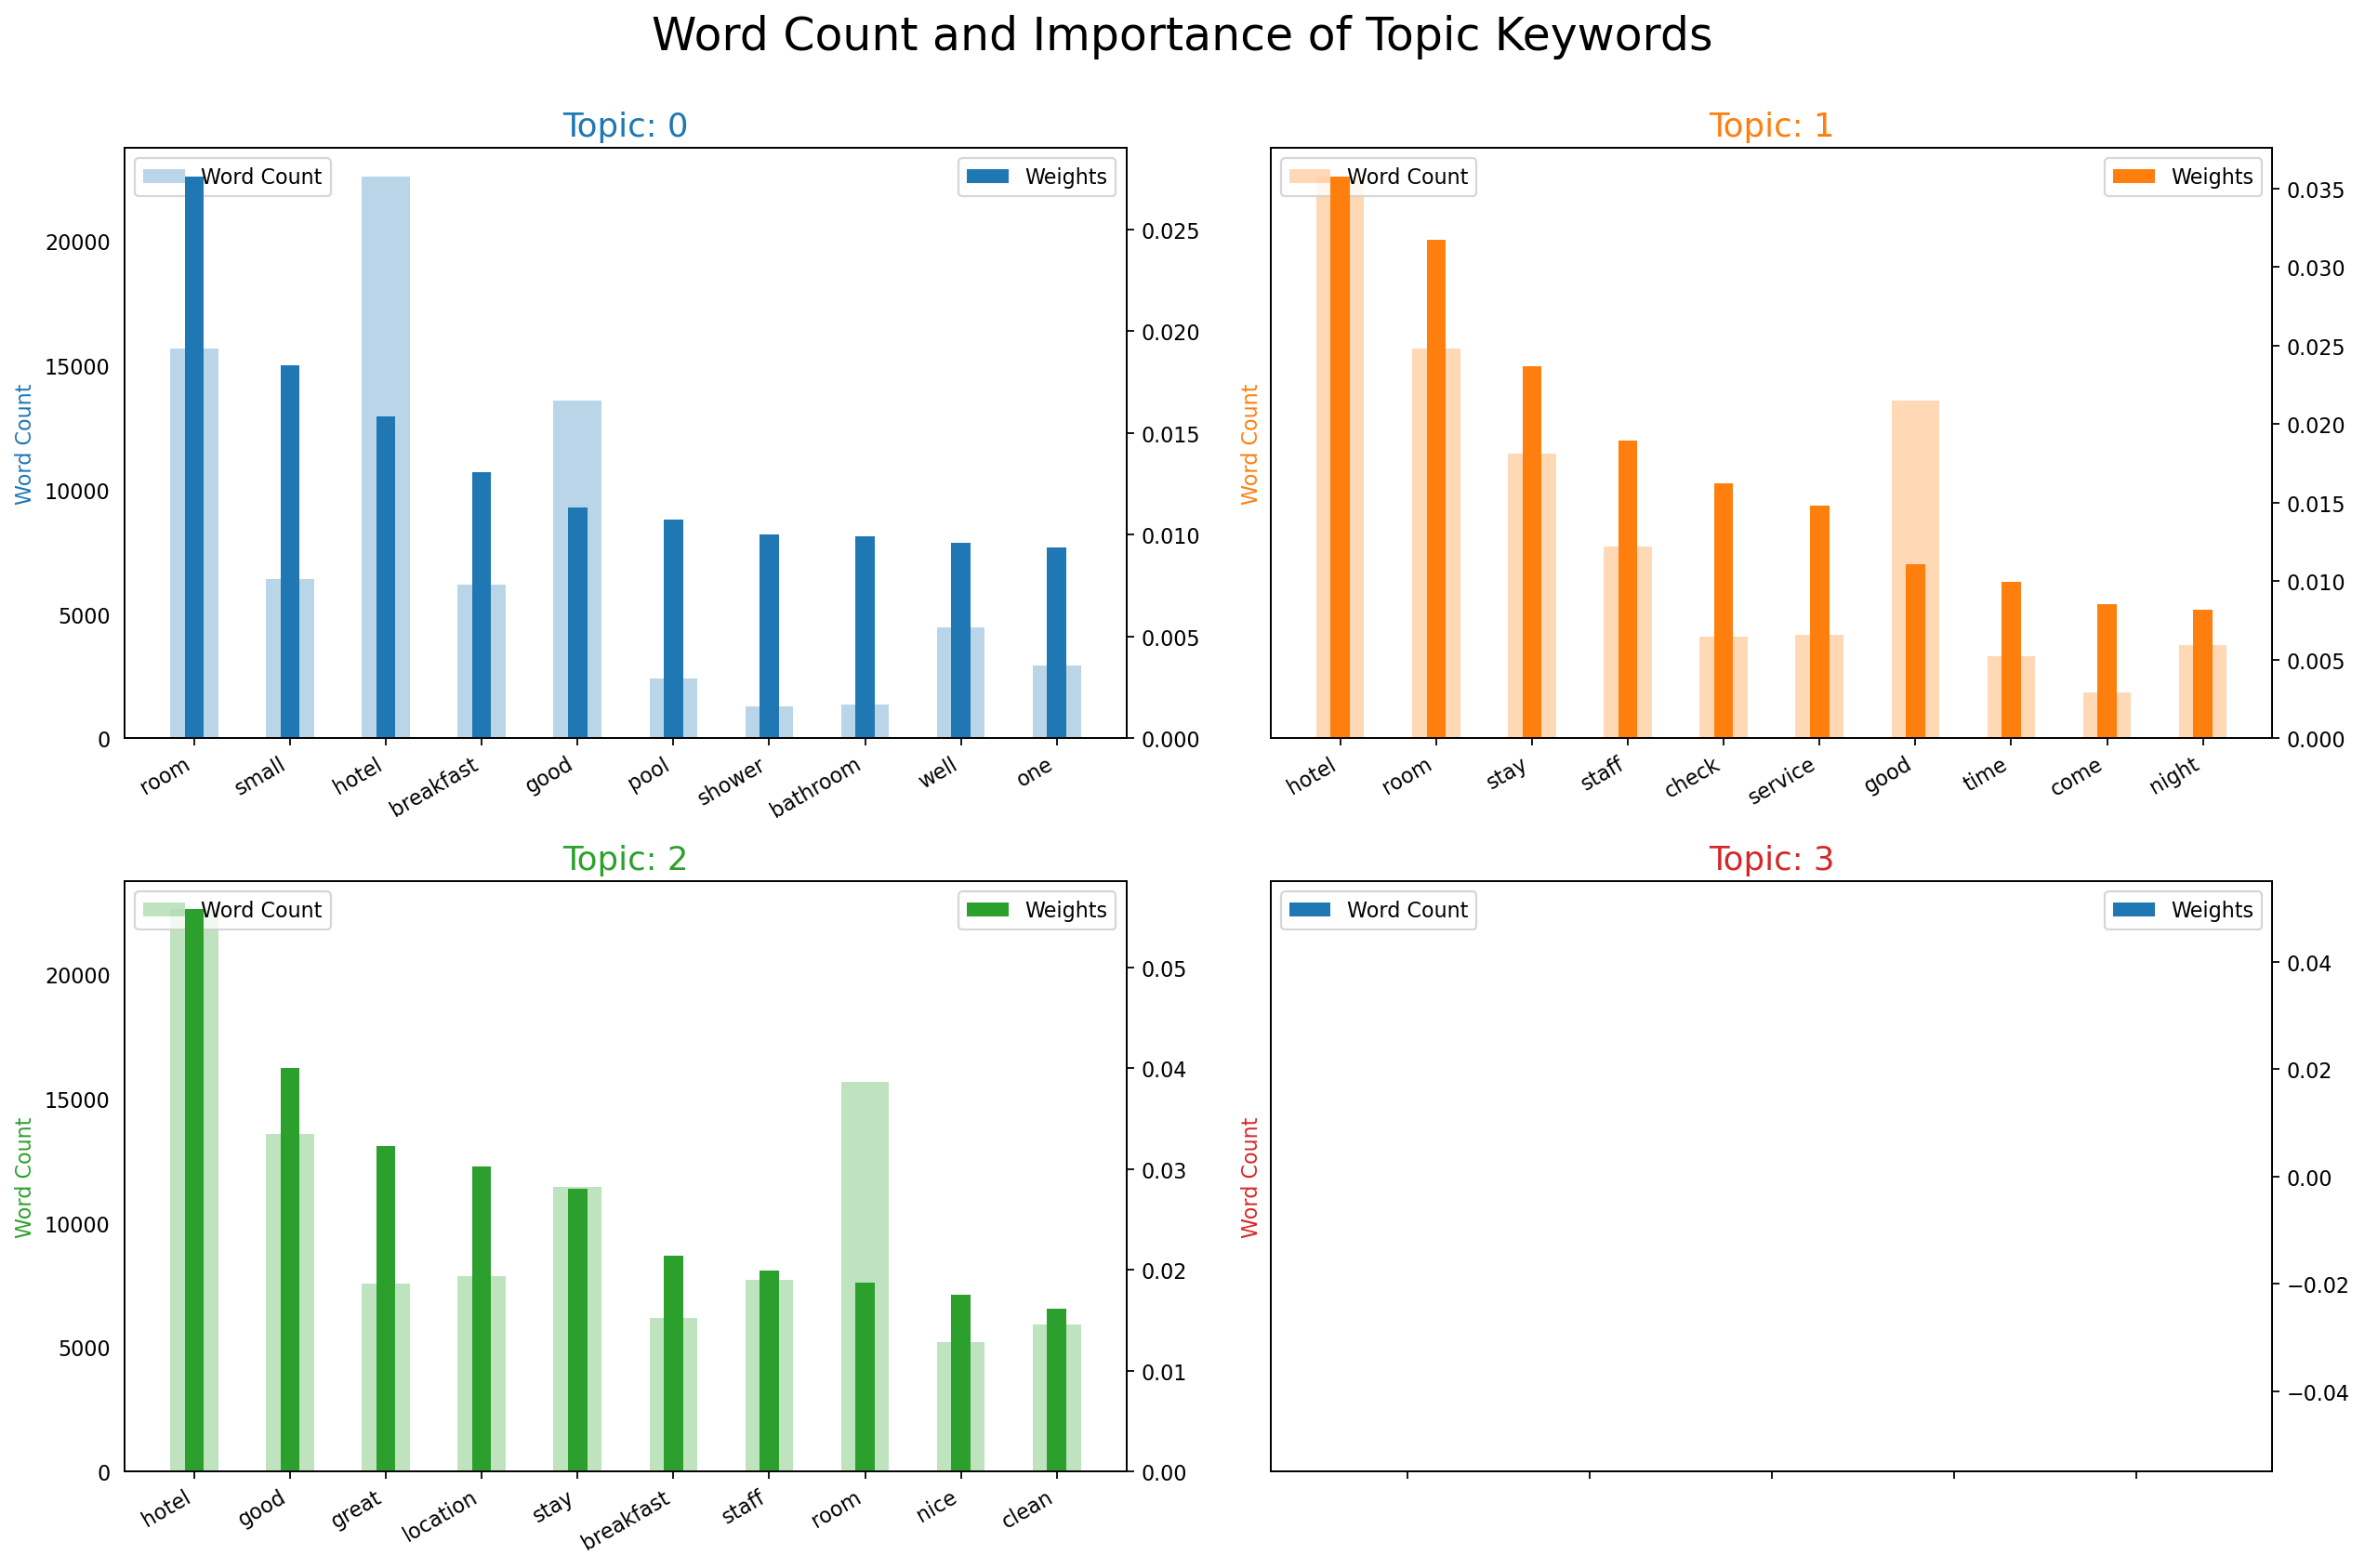

In [23]:
# Create a function to generate the plot
def plot_word_count_importance(topics, data_flat, title):
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i, weight, data_flat.count(word)])

    df_plot = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height='word_count', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height='importance', data=df_plot.loc[df_plot.topic_id == i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df_plot.loc[df_plot.topic_id == i, 'word'], rotation=30, horizontalalignment='right')
        ax.legend(loc='upper left')
        ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)
    fig.suptitle(title, fontsize=22, y=1.05)
    plt.show()

# Plotting all topics
plot_word_count_importance(topics_lem, data_flat_lem, 'Word Count and Importance of Topic Keywords')

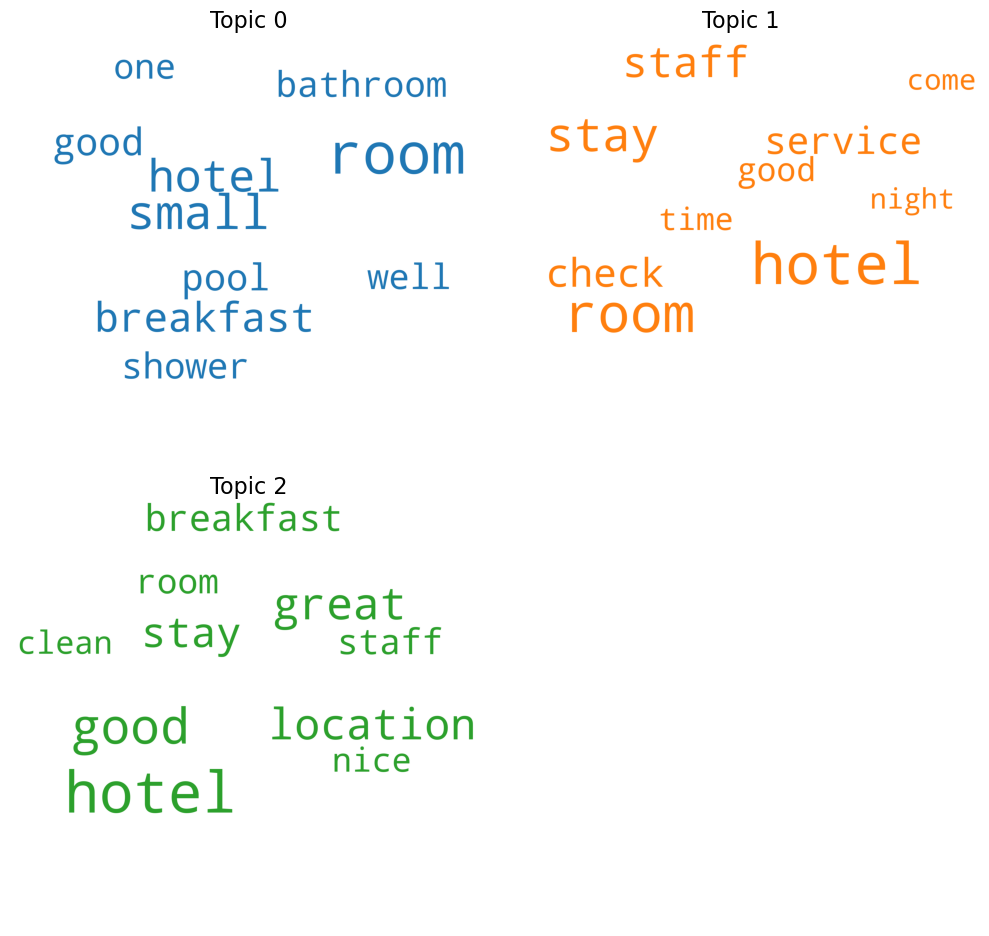

In [24]:
from wordcloud import WordCloud
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Create WordClouds for each topic in the dataset
clouds_pre = []

for i in range(3):
    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    topic_words = dict(lem_ldamodel.show_topic(i, topn=10))
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    clouds_pre.append(cloud)

# Plot the WordClouds for all topics
fig_pre, axes_pre = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes_pre.flatten()):
    fig_pre.add_subplot(ax)
    if i < len(clouds_pre):
        plt.gca().imshow(clouds_pre[i])
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [25]:
vis = pyLDAvis.gensim.prepare(topic_model=lem_ldamodel, corpus=lem_corpus, dictionary=lem_dict)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

We find that stem reviews produce a much higher coherence than lemmatized reviews, and thus will use stemmed reviews to conduct our analysis.

## Aspect Extraction

In [26]:
topics_stem

[(0,
  [('room', 0.028019654),
   ('shower', 0.02429848),
   ('water', 0.02003805),
   ('good', 0.016749734),
   ('bathroom', 0.016249016),
   ('small', 0.015367531),
   ('pool', 0.014033569),
   ('area', 0.01364396),
   ('well', 0.0131019065),
   ('bed', 0.012332016),
   ('hot', 0.012192612),
   ('floor', 0.011816955),
   ('also', 0.01121319),
   ('space', 0.010460705),
   ('free', 0.010154055),
   ('breakfast', 0.00998285),
   ('use', 0.009889977),
   ('one', 0.009070871),
   ('avail', 0.008202699),
   ('high', 0.008031354)]),
 (1,
  [('room', 0.048877396),
   ('hotel', 0.035052437),
   ('small', 0.017294107),
   ('one', 0.015194208),
   ('stay', 0.01469374),
   ('night', 0.014450712),
   ('get', 0.011605806),
   ('us', 0.011314762),
   ('breakfast', 0.010594836),
   ('even', 0.009225123),
   ('book', 0.009213377),
   ('bed', 0.008568587),
   ('could', 0.008473515),
   ('time', 0.0076296735),
   ('day', 0.0072289393),
   ('bad', 0.0071428926),
   ('size', 0.007104914),
   ('like', 0.

In [27]:
top_dict = {}
for i in topics_stem:
    top_dict[i[0]] = []
    for j in i[1]:
        top_dict[i[0]].append(j[0])

In [28]:
top_dict

{0: ['room',
  'shower',
  'water',
  'good',
  'bathroom',
  'small',
  'pool',
  'area',
  'well',
  'bed',
  'hot',
  'floor',
  'also',
  'space',
  'free',
  'breakfast',
  'use',
  'one',
  'avail',
  'high'],
 1: ['room',
  'hotel',
  'small',
  'one',
  'stay',
  'night',
  'get',
  'us',
  'breakfast',
  'even',
  'book',
  'bed',
  'could',
  'time',
  'day',
  'bad',
  'size',
  'like',
  'good',
  'would'],
 2: ['hotel',
  'good',
  'great',
  'breakfast',
  'stay',
  'room',
  'walk',
  'nice',
  'staff',
  'clean',
  'small',
  'pool',
  'well',
  'comfort',
  'food',
  'night',
  'area',
  'excel',
  'close',
  'also'],
 3: ['hotel',
  'stay',
  'staff',
  'room',
  'check',
  'great',
  'us',
  'help',
  'good',
  'time',
  'thank',
  'nice',
  'clean',
  'day',
  'front',
  'would',
  'back',
  'come',
  'alway',
  'also']}

In [29]:
df_res = pd.DataFrame(top_dict)
df_res

,0,1,2,3
0,room,room,hotel,hotel
1,shower,hotel,good,stay
2,water,small,great,staff
3,good,one,breakfast,room
4,bathroom,stay,stay,check
5,small,night,room,great
6,pool,get,walk,us
7,area,us,nice,help
8,well,breakfast,staff,good
9,bed,even,clean,time


In [30]:
df_res.to_csv('../../../data/lda/3-star LDA.csv')

## Import PyABSA

pyABSA acts as the ground truth in our analysis, and thus we will be tagging the pyABSA reviews to the topics identified above.

In [31]:
df_test = pd.read_json('../pyABSA_outputs/Aspect_Term_Extraction_and_Polarity_Classification_FAST_LCF_ATEPC.json')

In [32]:
df_test

,sentence,IOB,tokens,aspect,position,sentiment,probs,confidence
0,clean comfort hotel room find decent hotel tra...,"[O, B-ASP, O, O, O, O, O, O, O, B-ASP, O, O, O...","[clean, comfort, hotel, room, find, decent, ho...","[comfort, food, glass, closet space, port]","[[1], [9], [30], [37, 38], [47]]","[Positive, Negative, Negative, Negative, Negat...","[[0.022732432931661002, 0.002103362465277, 0.9...","[0.9752000000000001, 0.922, 0.8991, 0.86620000..."
1,good hotel great great place great room small ...,"[O, O, O, O, B-ASP, O, O, O, O, O, O, O, O, O,...","[good, hotel, great, great, place, great, room...",[place],[[4]],[Positive],"[[0.0005702517228200001, 0.0003066391509490000...",[0.9991000000000001]
2,good place decent price good place good price ...,"[O, O, O, B-ASP, O, O, O, O, O, O, O, O, B-ASP...","[good, place, decent, price, good, place, good...","[price, food]","[[3], [12]]","[Positive, Negative]","[[0.005487654823809001, 0.013030127622187, 0.9...","[0.9815, 0.912]"
3,great great staff neat hotel line star rate st...,"[O, O, B-ASP, O, O, O, O, O, O, B-ASP, I-ASP, ...","[great, great, staff, neat, hotel, line, star,...","[staff, front desk]","[[2], [9, 10]]","[Positive, Positive]","[[0.032106801867485005, 0.00041079759830600003...","[0.9675, 0.9994000000000001]"
4,good budget stay stay day nice seven eleven ne...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[good, budget, stay, stay, day, nice, seven, e...",[wait],[[18]],[Positive],"[[0.408927053213119, 0.019343916326761003, 0.5...",[0.5717]
...,...,...,...,...,...,...,...,...
68287,swiss hotel swiss stay hotel mani time recent ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[swiss, hotel, swiss, stay, hotel, mani, time,...","[size, staff, porter, crew]","[[15], [35], [67], [78]]","[Negative, Negative, Negative, Negative]","[[0.998076200485229, 0.001359648769721, 0.0005...","[0.9981000000000001, 0.9958, 0.9956, 0.9973000..."
68288,stay stay night wife ideal view th floor floor...,"[O, O, O, O, O, B-ASP, O, O, O, O, O, O, O, O,...","[stay, stay, night, wife, ideal, view, th, flo...","[view, staff, air]","[[5], [25], [45]]","[Positive, Positive, Positive]","[[0.09106669574975901, 0.0005153458332640001, ...","[0.9084000000000001, 0.8150000000000001, 0.9484]"
68289,great view great decent room one night hotel v...,"[O, B-ASP, O, O, B-ASP, O, O, O, O, O, O, O, O...","[great, view, great, decent, room, one, night,...","[view, room, bathroom]","[[1], [4], [23]]","[Positive, Positive, Positive]","[[0.000963231665082, 0.000514330400619, 0.9985...","[0.9985, 0.9973000000000001, 0.9973000000000001]"
68290,hotel date old four night mani cup machin shop...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B-ASP,...","[hotel, date, old, four, night, mani, cup, mac...","[bed, cover]","[[13], [18]]","[Positive, Positive]","[[0.07999674975872001, 0.000742122647352, 0.91...","[0.9193, 0.6769000000000001]"


In [39]:
##Get 3-star review from pyABSA
df_json = df_test.iloc[:len(df_filtered), :]

In [43]:
df_json = df_json[['sentence', 'tokens', 'aspect', 'sentiment', 'confidence']]

In [44]:
df_json

,sentence,tokens,aspect,sentiment,confidence
0,clean comfort hotel room find decent hotel tra...,"[clean, comfort, hotel, room, find, decent, ho...","[comfort, food, glass, closet space, port]","[Positive, Negative, Negative, Negative, Negat...","[0.9752000000000001, 0.922, 0.8991, 0.86620000..."
1,good hotel great great place great room small ...,"[good, hotel, great, great, place, great, room...",[place],[Positive],[0.9991000000000001]
2,good place decent price good place good price ...,"[good, place, decent, price, good, place, good...","[price, food]","[Positive, Negative]","[0.9815, 0.912]"
3,great great staff neat hotel line star rate st...,"[great, great, staff, neat, hotel, line, star,...","[staff, front desk]","[Positive, Positive]","[0.9675, 0.9994000000000001]"
4,good budget stay stay day nice seven eleven ne...,"[good, budget, stay, stay, day, nice, seven, e...",[wait],[Positive],[0.5717]
...,...,...,...,...,...
14065,small enough stay close station swim pool smal...,"[small, enough, stay, close, station, swim, po...",[pool],[Negative],[0.9987]
14066,great visit recent short day night must say ho...,"[great, visit, recent, short, day, night, must...","[music staff, breakfast, seat]","[Positive, Positive, Positive]","[0.9993000000000001, 0.9877, 0.9976]"
14067,good hotel great husband stay night halfway st...,"[good, hotel, great, husband, stay, night, hal...","[pool, view roof staff, wait]","[Neutral, Positive, Negative]","[0.5546, 0.9799, 0.9924000000000001]"
14068,stay hotel staff room passageway room b room l...,"[stay, hotel, staff, room, passageway, room, b...","[staff, snack bar, rice, food, cook]","[Neutral, Negative, Negative, Negative, Negative]","[0.5675, 0.9833000000000001, 0.7992, 0.9967, 0..."


## Get PyABSA topics

In [45]:
def get_topics(lst, dictionary, sentiment, confidence, topics_list, vectorizer, transformer, model):
    ans = []
    for word in range(len(lst)):
        docbow = dictionary.doc2bow([lst[word]])
        if len(docbow) == 0:
            tpc = get_cosine_similarity(lst[word], topics_list, vectorizer, transformer)
            res = (tpc, sentiment[word], confidence[word])
        else:
            tpc = model.get_document_topics(docbow)
            new_tpc = []
            max_val = 0
            max_tpc = -1
            for c, v in tpc:
                if v > max_val:
                    max_val = v
                    max_tpc = c
            res = (max_tpc, sentiment[word], confidence[word])
        ans.append(res)
    return ans

In [46]:
def get_cosine_similarity(word, topics_list, vectorizer, transformer):
    aspect_vec = vectorizer.transform([word])
    aspect_trf = transformer.transform(aspect_vec)
    cos_res = {}
    for i in range(len(topics_list.columns)):
        topic_words_vec = vectorizer.transform(list(topics_list[i]))
        topic_words_trf = transformer.transform(topic_words_vec)
        r = cosine_similarity(aspect_trf, topic_words_trf)
        cos_sim = np.rad2deg(np.arccos(r))
        
        mid_res = []
        for j in cos_sim:
            min_cos_sim = min(j)
            mid_res.append(min_cos_sim)
        cos_res[i] = mid_res
    min_val = 90
    min_topic = -1
    for k, v in cos_res.items():
        if v[0] < min_val:
            min_val = v
            min_topic = k
    return k

In [47]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
import scipy.sparse

In [48]:
df_filtered['vec_tokens'] = df_filtered['stem_tokens'].apply(lambda x: ' '.join(x))

In [49]:
df_filtered['stem_tokens']

0       [clean, comfort, hotel, find, decent, hotel, t...
1       [good, hotel, great, great, place, great, room...
2       [good, place, decent, price, good, place, good...
3       [great, great, staff, neat, hotel, line, star,...
4       [good, budget, stay, stay, day, nice, seven, e...
                              ...                        
2199    [small, enough, stay, close, station, swim, po...
2201    [great, recent, short, day, night, must, say, ...
2202    [good, hotel, great, husband, stay, night, hal...
2206    [stay, hotel, staff, passageway, room, b, room...
2208    [great, hotel, cut, hotel, night, cool, look, ...
Name: stem_tokens, Length: 14070, dtype: object

In [50]:
vectorizer = CountVectorizer()
transformer = TfidfTransformer()

filtered_vec = vectorizer.fit_transform(df_filtered['vec_tokens'])
filtered_trf = transformer.fit_transform(filtered_vec)

In [51]:
df_json['topics'] = np.empty((len(df_json), 0)).tolist()

In [52]:
df_json

,sentence,tokens,aspect,sentiment,confidence,topics
0,clean comfort hotel room find decent hotel tra...,"[clean, comfort, hotel, room, find, decent, ho...","[comfort, food, glass, closet space, port]","[Positive, Negative, Negative, Negative, Negat...","[0.9752000000000001, 0.922, 0.8991, 0.86620000...",[]
1,good hotel great great place great room small ...,"[good, hotel, great, great, place, great, room...",[place],[Positive],[0.9991000000000001],[]
2,good place decent price good place good price ...,"[good, place, decent, price, good, place, good...","[price, food]","[Positive, Negative]","[0.9815, 0.912]",[]
3,great great staff neat hotel line star rate st...,"[great, great, staff, neat, hotel, line, star,...","[staff, front desk]","[Positive, Positive]","[0.9675, 0.9994000000000001]",[]
4,good budget stay stay day nice seven eleven ne...,"[good, budget, stay, stay, day, nice, seven, e...",[wait],[Positive],[0.5717],[]
...,...,...,...,...,...,...
14065,small enough stay close station swim pool smal...,"[small, enough, stay, close, station, swim, po...",[pool],[Negative],[0.9987],[]
14066,great visit recent short day night must say ho...,"[great, visit, recent, short, day, night, must...","[music staff, breakfast, seat]","[Positive, Positive, Positive]","[0.9993000000000001, 0.9877, 0.9976]",[]
14067,good hotel great husband stay night halfway st...,"[good, hotel, great, husband, stay, night, hal...","[pool, view roof staff, wait]","[Neutral, Positive, Negative]","[0.5546, 0.9799, 0.9924000000000001]",[]
14068,stay hotel staff room passageway room b room l...,"[stay, hotel, staff, room, passageway, room, b...","[staff, snack bar, rice, food, cook]","[Neutral, Negative, Negative, Negative, Negative]","[0.5675, 0.9833000000000001, 0.7992, 0.9967, 0...",[]


In [53]:
for i, r in df_json.iterrows():
    asp = r['aspect']
    sent = r['sentiment']
    confid = r['confidence']
    tpc = get_topics(asp, stem_dict, sent, confid, df_res, vectorizer, transformer, stem_ldamodel)
    tpcs = r['topics']
    for i in tpc:
        tpcs.append(i)
    r['topics'] = tpcs

In [54]:
print(f"The number of reviews without any topics is {sum(df_json['topics'].apply(lambda x: len(x) == 0))}")
print(f"The number of reviews with exactly one topic is {sum(df_json['topics'].apply(lambda x: len(x) == 1))}")
print(f"The number of reviews with more than one topic is {sum(df_json['topics'].apply(lambda x: len(x) > 1))}")

The number of reviews without any topics is 460
The number of reviews with exactly one topic is 3399
The number of reviews with more than one topic is 10211


In [55]:
df_json.to_csv('3star_pyABSA_updated.csv')